# The MovieLens Dataset

## Getting the Data

- the MovieLens 100K dataset
  - 100,000 ratings 
  - ranging from 1 to 5 stars
  - from 943 users
  - on 1682 movies
  - each user has at least 20 ratings
- download the data from [here](https://files.grouplens.org/datasets/movielens/ml-100k.zip)

In [1]:
import os
import pandas as pd
import torch

In [2]:
#@save
def read_data_ml100k():
    data_dir = "./data/ml-100k"
    names = ['user_id', 'item_id', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(data_dir, 'u.data'), sep='\t',
                       names=names, engine='python')
    num_users = data.user_id.unique().shape[0]
    num_items = data.item_id.unique().shape[0]
    return data, num_users, num_items

## Statistics of the Dataset

In [3]:
data, num_users, num_items = read_data_ml100k()
sparsity = 1 - len(data) / (num_users * num_items) # 这里可以理解成我们要构建一个矩阵，其中有多少个元素是没有数据的，这个比例就是稀疏度
print(f'number of users: {num_users}, number of items: {num_items}')
print(f'matrix sparsity: {sparsity:f}')
print(data.head(5))

number of users: 943, number of items: 1682
matrix sparsity: 0.936953
   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596


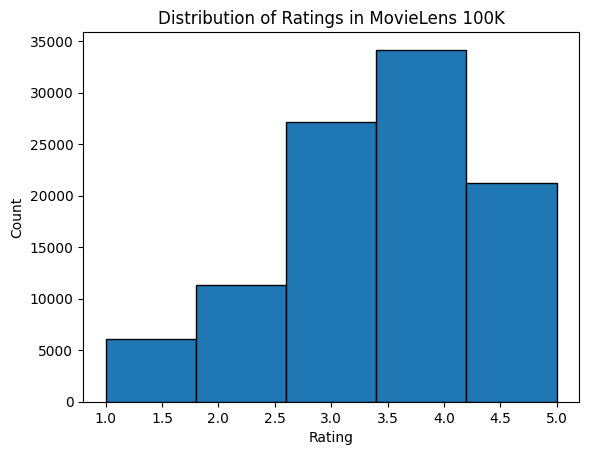

In [4]:
import matplotlib.pyplot as plt
plt.hist(data['rating'], bins=5, ec='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings in MovieLens 100K')
plt.show()

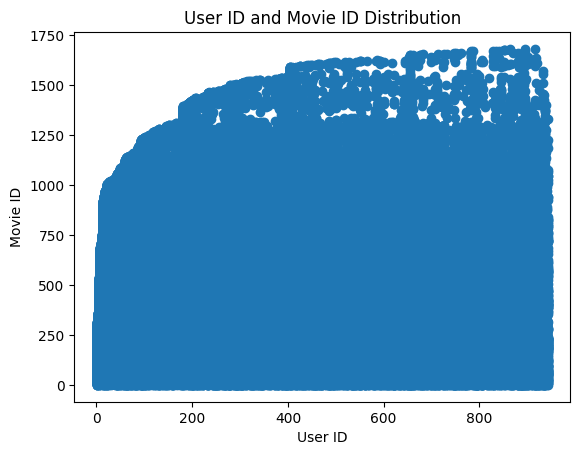

In [5]:
plt.scatter(data['user_id'], data['item_id'])
plt.xlabel('User ID')
plt.ylabel('Movie ID')
plt.title('User ID and Movie ID Distribution')
plt.show()

## Splitting the dataset

In [5]:
import numpy as np
#@save
def split_data_ml100k(data, num_users, num_items,
                      split_mode='random', test_ratio=0.1):
    """Split the dataset in random mode or seq-aware mode."""
    if split_mode == 'seq-aware':
        train_items, test_items, train_list = {}, {}, []
        for line in data.itertuples():
            u, i, rating, time = line[1], line[2], line[3], line[4]
            train_items.setdefault(u, []).append((u, i, rating, time))
            if u not in test_items or test_items[u][-1] < time:
                test_items[u] = (i, rating, time)
        for u in range(1, num_users + 1):
            train_list.extend(sorted(train_items[u], key=lambda k: k[3]))
        test_data = [(key, *value) for key, value in test_items.items()]
        train_data = [item for item in train_list if item not in test_data]
        train_data = pd.DataFrame(train_data)
        test_data = pd.DataFrame(test_data)
    else:
        mask = [True if x == 1 else False for x in np.random.uniform(
            0, 1, (len(data))) < 1 - test_ratio]
        neg_mask = [not x for x in mask]
        train_data, test_data = data[mask], data[neg_mask]
    return train_data, test_data

## Loading the data

In [6]:
#@save
def load_data_ml100k(data, num_users, num_items, feedback='explicit'):
    users, items, scores = [], [], []
    inter = np.zeros((num_items, num_users)) if feedback == 'explicit' else {}
    for line in data.itertuples():
        user_index, item_index = int(line[1] - 1), int(line[2] - 1)
        score = int(line[3]) if feedback == 'explicit' else 1
        users.append(user_index)
        items.append(item_index)
        scores.append(score)
        if feedback == 'implicit':
            inter.setdefault(user_index, []).append(item_index)
        else:
            inter[item_index, user_index] = score
    return users, items, scores, inter

In [7]:
class ML100KDataset(torch.utils.data.Dataset):
    def __init__(self, users, items, ratings):
        assert len(users) == len(items) == len(ratings)
        self.users = users
        self.items = items
        self.ratings = ratings

    def __getitem__(self, index):
        return (self.users[index], self.items[index],
                self.ratings[index])

    def __len__(self):
        return len(self.users)

def split_and_load_ml100k(split_mode='seq-aware', feedback='explicit',
                          test_ratio=0.1, batch_size=256):
    data, num_users, num_items = read_data_ml100k()
    train_data, test_data = split_data_ml100k(
        data, num_users, num_items, split_mode, test_ratio)
    train_u, train_i, train_r, _ = load_data_ml100k(
        train_data, num_users, num_items, feedback)
    test_u, test_i, test_r, _ = load_data_ml100k(
        test_data, num_users, num_items, feedback)
    train_set = ML100KDataset(
        train_u, train_i, train_r)
    test_set = ML100KDataset(
        test_u, test_i, test_r)
    train_iter = torch.utils.data.DataLoader(
        train_set, batch_size, shuffle=True, drop_last=True)
    test_iter = torch.utils.data.DataLoader(test_set, batch_size)
    return num_users, num_items, train_iter, test_iter